In [29]:
import numpy as np, sys, os, holoviews as hv, scipy
sys.path.insert(0, '../') # add normal modules
from Utils import IO, plotting as plotz

root = '../Data/new13/2019-07-02T14:47:56.913797'
data = IO.DataLoader(root)

settings = {k: IO.Settings(os.path.join(root, k)) for k in data}

import multiprocessing as mp
from multiprocessing.pool import ThreadPool
processes = mp.cpu_count()

aucs = loadedData = {}
for idx, (k, v) in enumerate(data.items()):
    tmp = os.path.join(root, k)
    setting = settings[k]
    
    tmp_worker = IO.Worker(v, settings[k])
    with ThreadPool(processes = processes) as p:
        p.map(tmp_worker, tmp_worker.idx)
        v = np.frombuffer(tmp_worker.buff, dtype = np.float64).reshape(*tmp_worker.buffshape)    
    del tmp_worker
    s = v.shape
    v = v.reshape(-1, setting.nNodes, setting.deltas // 2 - 1)
    v = np.array([(i - i.min()) / (i.max() - i.min()) for i in v])
    v = v.reshape(-1, s[-1])
    loadedData[k] = v.reshape(s)
    
    if idx >= 10:
        break
    
    




  0%|          | 0/21 [00:00<?, ?it/s]

Extracting data...
Done
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T14:47:56.919834: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T14:59:24.065868: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T15:10:48.334562: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T15:21:55.155541: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T15:32:27.188444: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T15:43:20.929482: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T15:54:21.391680: using json
loading graph
Reading settings in ../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T16:05:59.721509: using json
loading graph


100%|██████████| 21/21 [00:02<00:00,  7.98it/s]


In [35]:
# a = next(iter(data))
# data[a]['0.8']['1']
# aucs = {}
# for k, v in loadedData.items():
#     aucs[k] = np.trapz(v.squeeze(), axis = -1)
#     print(aucs[k].shape)
# 
#     
# from Utils.misc import flattenDict
# 
# d = flattenDict(data)
# for i in d[:5]:
#     print(i)

In [30]:
def worker(sample):
    # tmp workaround
    if len(sample.shape) == 1:
        sample = sample.reshape(-1, 1)
    auc = np.zeros((len(sample), 2))
    coeffs, errors = plotz.fit(sample, func, params = fitParam)
    for nodei, c in enumerate(coeffs):
        tmp = 0
        F      = lambda x: func(x, *c) - c[0]
        tmp, _ = scipy.integrate.quad(F, 0, LIMIT)
        auc[nodei, 0] = tmp
        auc[nodei, 1] = errors[nodei]
        if errors[nodei] > .1:
            print('error large')
    auc[auc < np.finfo(auc.dtype).eps ] = 0
    return auc[:, 0]
from tqdm import tqdm

double = lambda x, a, b, c, d, e, f: a + b * np.exp(-c*(x)) + d * np.exp(- e * (x-f))

double_= lambda x, b, c, d, e, f: b * np.exp(-c*(x)) + d * np.exp(- e * (x - f ))
single = lambda x, a, b, c : a + b * np.exp(-c * x)
single_= lambda x, a, b, c : a + b * np.exp(-c * x)
special= lambda x, a, b, c, d: a  + b * np.exp(- (x)**c - d)

func        = double
p0          = np.ones((func.__code__.co_argcount - 1)); # p0[0] = 0
fitParam    = dict(maxfev = int(1e6), \
                   bounds = (0, np.inf), p0 = p0,\
                   jac = 'cs')
aucs = {}
for k, v in tqdm(loadedData.items()):
    setting = settings[k]
    LIMIT = setting.deltas // 2 - 1
    LIMIT = np.inf
    s = v.shape
    v = v.reshape(-1, *s[-2:])
    with mp.Pool(mp.cpu_count()) as p:
        auc = np.asarray(p.map(worker, v)).reshape(s[:-1])
    aucs[k] = auc

100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


# Notes on the data

Rick mentioned that it could be the case that although the data does not look linear, it is because each graph has some slightly odd behavior in regards of how the entropy decays. Meaning, it could be that across graphs the lines are not necessarily on a line. However, the prediction accuracy should still be high.

Things to check:
    - Check the ordering over time of the curves for different datasets
    - Check the prediction accuracy
    

In [34]:
for k in data:
    for j in data[k]:
        print(k, j, data[k][j].keys())
from Utils.misc import flattenDict

for k in flattenDict(data)[:10]:
    print(k)

2019-07-02T14:47:56.919834 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T14:59:24.065868 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T15:10:48.334562 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T15:21:55.155541 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T15:32:27.188444 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T15:43:20.929482 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T15:54:21.391680 0.5 odict_keys(['control', '0.5', 'inf'])
2019-07-02T16:05:59.721509 0.5 odict_keys(['control', '0.5', 'inf'])
../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T14:47:56.919834/0.5/control/2019-07-02T14:48:37.449483_nSamples=10000_deltas=30_repeats=20000_updateType=.25_pulse={}.pickle
../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T14:47:56.919834/0.5/0.5/2019-07-02T14:49:12.980586_nSamples=10000_deltas=30_repeats=20000_updateType=.25_pulse={'0': 0.5}.pickle
../Data/new13/2019-07-02T14:47:56.913797/2019-07-02T14:47:56.919834/0.5/0.5/2019-07-02T14:

In [32]:
from bokeh import plotting as bp
from bokeh.models import ColumnDataSource, CustomJS
import bokeh
bp.output_notebook()


tmp_aucs = [i.squeeze() for i in aucs.values()]
x = []

sets = [0, 1]

for i in tmp_aucs:
    idx = i[sets[0]].argmax()
#     tmp = i[sets].max(-1)
    tmp  = i[sets, idx]
#     print(i.shape)
    x.append(tmp)

tmp_aucs = np.asarray(x)
# print(tmp_aucs.shape, idx.shape); assert 0

tmp_mi   = [loadedData[i].squeeze() for i in aucs.keys()]
tmp_mi   = tmp_mi

viridis = bokeh.palettes.Viridis256
# setup data
buffer          = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [], \
                                               color = [])\
                                  )

buffer_causal   = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [],\
                                              color = []),\
                                  )

aucs_bokeh = ColumnDataSource('x', 'y', data = dict(x = tmp_aucs[:,0].tolist(), \
                                                    y = tmp_aucs[:, 1].tolist(), \
                                                    ),\
                              )

mi_bokeh    = ColumnDataSource(data = dict(y = [i[0].tolist() for i in tmp_mi]))
causal_bokeh= ColumnDataSource(data = dict(y = [i[sets[-1]].tolist() for i in tmp_mi]))

f1 = bp.figure(tools = 'hover tap lasso_select'.split(), width = 300)
f2 = bp.figure( height = int(f1.plot_height * .5 ))
f3 = bp.figure( height = int(f1.plot_height * .5 ))

for prop, label in zip('yaxis xaxis'.split(), ['Mutual information', 'time']):
    getattr(f2, prop).axis_label = label

for prop, label in zip('yaxis xaxis'.split(), ['Causal impact', 'time']):
    getattr(f3, prop).axis_label = label
f1.scatter('x', 'y', source = aucs_bokeh, size = 10)
f2.multi_line('x', 'y', source = buffer, color = 'color')
f3.multi_line(xs = 'x', ys = 'y', source = buffer_causal, color = 'color')

with open('dashboard.js', 'r') as f:
    callback = ''.join(i for i in f.readlines())
    
    JS =  CustomJS(\
             args = dict(buffer = buffer, \
                         mi     = mi_bokeh, \
                         buffer_causal = buffer_causal, \
                         causal = causal_bokeh, 
                         colors = bokeh.palettes.Magma256,\
              ),\
             code = callback)
aucs_bokeh.selected.js_on_change('indices', \
                                JS)
bp.show(bokeh.layouts.row(f1, bokeh.layouts.column(f2, f3)))


Loading BokehJS ...

# AUC for all data

showing the data for not only the driver-node

In [27]:
# aucs = {}
# for k, v in loadedData.items():
#     v = v.squeeze()
#     s = v.shape
#     v = v.reshape(v.shape[0], -1)
#     mi, ma = v.min(1), v.max(1)
#     print(v.shape)
#     mi = mi[:, None]
#     ma = ma[:, None]
# 
#     v = (v - mi) / (ma - mi)
#     print(v.max(1))
#     v = v.reshape(s)
#     aucs[k] = np.trapz(v, axis = -1)

predictions = np.zeros((len(loadedData), 2))

for idx, (k, v) in enumerate(aucs.items()):
    jdx = v.squeeze().argmax(-1)
    tmp = jdx[0] == jdx[1:]
#     print(jdx, v.shape)
    predictions[idx] = tmp

fig = bp.figure()
colors = bokeh.palettes.Viridis256

N = len(colors) // len(aucs)
for idx,(k, v) in enumerate(aucs.items()):
    fig.scatter(*v.squeeze()[[0,2]], color = colors[idx * N])
print(predictions.mean(0))
bp.show(fig)

[0.4 0.6]


In [40]:
# tmp_aucs = np.asarray([i for i in aucs.values()]).squeeze()

# tmp_aucs = np.sort(tmp_aucs, axis = -1)[..., -1:]

# print(tmp_aucs.shape)
# fig, ax = plt.subplots()
# colors = plt.cm.Spectral(np.linspace(0, 1, len(tmp_aucs)))
# [ax.scatter(*i[:2], color = colors[idx]) for idx, i in enumerate(tmp_aucs)]
# fig.show()


In [41]:
aucs

{'2019-06-20T17:03:28.729187': array([[[[1.12850398e+01, 7.83687319e+00, 1.68365615e+01,
           1.78574123e+01, 1.36784834e+01, 1.83463158e+01,
           2.02458032e+01, 4.49622059e+00, 3.61765706e+00,
           3.99592173e+00, 2.79197335e+01, 4.52481507e+00,
           2.18133097e+01, 2.14267990e+01, 4.20007091e+00,
           2.44175679e+01, 4.31328383e+00, 2.19017319e+01,
           1.40072658e+01, 1.71958586e+01]]],
 
 
        [[[3.00457042e+00, 1.06235870e+01, 5.01378917e-02,
           8.48458472e+00, 1.16430608e+01, 6.10863962e+00,
           1.06235870e+01, 2.02833487e+01, 6.10376225e-01,
           3.34227650e-02, 3.00699347e+00, 1.12631032e+01,
           8.15893762e+00, 8.48458472e+00, 1.16430608e+01,
           6.10863962e+00, 1.06235870e+01, 2.02833487e+01,
           6.10376225e-01, 3.34227650e-02]]],
 
 
        [[[3.84828521e+01, 8.85436698e+00, 4.94228151e+00,
           4.89320843e+00, 6.17515231e+00, 2.35796261e+01,
           6.27249008e+00, 1.11766723e+01, 8

IndexError: index 7 is out of bounds for axis 1 with size 1

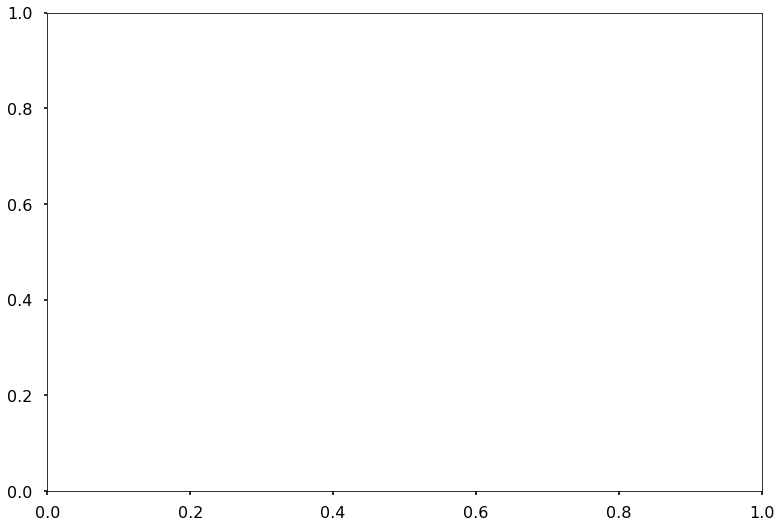

In [42]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn-poster')
fig, ax = plt.subplots()
sets = [0, 1]
for k, v in aucs.items():
    idx = v[sets[-1]].argmax()
    ax.scatter(*v[sets, idx], marker = '.')
    ax.scatter(*v[sets, :].max(1), marker = '.')
    ax.set(xlabel = 'informational impact', ylabel = 'causal impact')
    
fig.show()

In [ ]:
# make confusion matrices
from sklearn.metrics import confusion_matrix

tmp = np.zeros((len(aucs), 2))
for idx, (k, v) in enumerate(aucs.items()):
    jdx = np.argmax(v, axis = -1)
    tmp[idx] = jdx[0] == jdx[1:]
print(tmp.mean(0))


In [ ]:
from matplotlib import style
import matplotlib.pyplot as plt
style.reload_library()
%matplotlib inline
style.use('seaborn-poster')
fig, ax = plt.subplots(3,1, sharex = 'all')
labels = '0.5 1 inf'.split()
print(len(aucs))
for k, v in aucs.items():
    tmp = v.squeeze()
    jdx = np.argsort(tmp, axis = -1)[:, -1]
#     print([tmp[i, j] for i, j in enumerate(jdx)])
    for idx, axi in enumerate(ax):
        y = tmp[[0, idx + 1]]
        axi.scatter(*y[:, jdx[idx + 1]], color = 'blue', alpha = .2)
#         axi.scatter(*tmp[[0, idx + 1]].max(-1), color = 'red', alpha = .2)
        axi.set_title(labels[idx])
    
mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set(xlabel = 'Informational impact', ylabel = 'Causal impact')

fig.subplots_adjust(wspace = .3)

axi.legend(handles = [plt.Line2D([0], [0], color = i, label = j) for i, j in zip(\
                    'blue red'.split(), 'matched max'.split())], bbox_to_anchor = (1.15, 1))
fig.show()

In [ ]:
import networkx as nx
perc = np.zeros((len(aucs), 2))

# fig, ax = plt.subplots(3, 1, figsize = (10, 16))
colors = plt.cm.gist_ncar(np.linspace(0, 1, len(aucs)))

labels = "Informational impact\tUnderwhelming causal".split('\t')
for idx, (k, v) in enumerate(aucs.items()):
    
    tmp = np.argsort(v.squeeze(), axis = -1)[:, -1]
    perc[idx] = tmp[[0]] == tmp[[1, 2]]
    if not perc[idx, 0]:
        d = loadedData[k].squeeze()
        gs = dict(\
                 width_ratios = [1, 1, 1]\
                 )
        fig, ax = plt.subplots(1,3, gridspec_kw = gs)
        
        mainax = fig.add_subplot(111, \
                 frameon = 0, xticks = [], yticks = [])
        mainax.set_title(k, pad = 25)
        colors = plt.cm.Spectral(np.linspace(0, 1, settings[k].nNodes))
        g = settings[k].graph
        g = nx.node_link_graph(g)
        pos    = nx.circular_layout(g)
        subset = np.argsort(v.squeeze(), -1)[:, -2:]
        print(subset)
        for kk, axi in enumerate(ax[:2]):
            sub = subset[kk]
            [axi.plot(i, color = c, alpha = .4) for i, c in zip(d[kk, sub], colors[sub])]
            axi.set_title(labels[kk])
        nx.draw_networkx_nodes(g, pos = pos, node_color = colors, ax = ax[-1])
        nx.draw_networkx_edges(g, pos = pos, ax = ax[-1])
        ax[-1].set_aspect('equal', 'box')
        ax[-1].axes.axis('off')
        
            
        
#     vv = loadedData[k]
#     for jdx, label in enumerate(tmp):
#         axi = ax[jdx]
#         d = loadedData[k].squeeze()
#         print(d.shape)
#         axi.scatter(*d[[0, jdx + 1], label, :])
#         axi.plot(vv.squeeze()[jdx, label, :])
        
    
print(perc.mean(0), perc.std(0))


In [ ]:
fig, ax = plt.subplots()
for k, v in aucs.items():
    ax.scatter(*v[[0,1]].squeeze())
fig.savefig('test.png')

import networkx as nx
nx.from_pan
nx.from_edgelist([[0,1], [1,0]])